In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.calibration import calibration_curve
from IPython.display import HTML

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import (
    FEATURE_CACHE_PATH,
    ACTIVE_MODEL_VERSION,
    ACTIVE_FEATURES,
    get_display_name,
    get_ale_filename,
    FEATURE_BOUNDS,
)
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling import CreditRiskLogit, compute_ece, compute_ale_for_feature, compute_ale_binary
from credit_risk_xai.modeling.train import DEFAULT_PARAMS, run_lightgbm_training
from credit_risk_xai.plotting import (
    set_thesis_style, set_subfigure_style, reset_to_standalone_style,
    COLORS, FIGSIZE, save_figure, despine, add_identity_line,
)

FIGURES_DIR = PROJ_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

# Initialize thesis-quality plotting style
set_thesis_style(use_tex=True)

print(f"Model version: {ACTIVE_MODEL_VERSION} ({len(ACTIVE_FEATURES)} features)")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model version: v2 (22 features)


# Chapter 1: Global Model Understanding


In [2]:
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[
    (df["ser_aktiv"] == 1) & 
    (df["sme_category"].isin(["Small", "Medium"])) & 
    (df["knc_kncfall"] == 1) &
    (df["bransch_borsbransch_konv"] != "40.0")
]

X, y = prepare_modeling_data(df)
n_default = (y == 1).sum()
n_non_default = (y == 0).sum()
print(f"Data: {len(X):,} samples ({n_non_default:,} non-default, {n_default:,} default), {X.shape[1]} features")

Data: 304,149 samples (298,795 non-default, 5,354 default), 22 features


In [3]:
results = run_lightgbm_training(X=X, y=y, use_wandb=False)

[50]	training's binary_logloss: 0.0616846	valid_1's binary_logloss: 0.0673924
[100]	training's binary_logloss: 0.0583939	valid_1's binary_logloss: 0.066455
[150]	training's binary_logloss: 0.0561879	valid_1's binary_logloss: 0.0661763
[200]	training's binary_logloss: 0.0543006	valid_1's binary_logloss: 0.0660327


In [4]:
model = results["model"]
X_train, X_val = results["X_train"], results["X_val"]
y_train, y_val = results["y_train"], results["y_val"]
y_pred_proba = results["y_val_proba"]

print(f"Training samples: {len(X_train):,}, Validation samples: {len(X_val):,}")
print(f"LightGBM: AUC={roc_auc_score(y_val, y_pred_proba):.4f}, LogLoss={log_loss(y_val, y_pred_proba):.4f}")

Training samples: 243,319, Validation samples: 60,830
LightGBM: AUC=0.8972, LogLoss=0.0660


# Phase 1: Foundation & Baseline Comparison

Following the comprehensive XAI thesis plan, we'll establish baselines and infrastructure for all subsequent analyses.

In [5]:
logit_model = CreditRiskLogit()
logit_model.fit(X_train, y_train)

logit_val_proba = logit_model.predict_proba(X_val)[:, 1]
X_train_processed = logit_model.transform(X_train)
X_val_processed = logit_model.transform(X_val)

print(f"Logit: AUC={roc_auc_score(y_val, logit_val_proba):.4f}, LogLoss={log_loss(y_val, logit_val_proba):.4f}")

summary_df = logit_model.summary()

# Map feature names to display names
summary_df['feature'] = summary_df['feature'].apply(
    lambda x: 'Intercept' if x == 'intercept' else get_display_name(x)
)

# Sort by p-value and select columns for the table
summary_df = summary_df.sort_values('p_value')
summary_df = summary_df[['feature', 'coef', 'robust_se', 'z_score', 'p_value']]

# Add significance stars
def sig_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    return ''

summary_df['sig'] = summary_df['p_value'].apply(sig_stars)

# Format for display
summary_df_display = summary_df.copy()
summary_df_display['coef'] = summary_df_display['coef'].map('{:.4f}'.format)
summary_df_display['robust_se'] = summary_df_display['robust_se'].map('{:.4f}'.format)
summary_df_display['z_score'] = summary_df_display['z_score'].map('{:.2f}'.format)
summary_df_display['p_value'] = summary_df_display['p_value'].map('{:.4f}'.format)

# Rename columns for LaTeX
summary_df_display.columns = ['Feature', 'Coefficient', 'Robust SE', '$z$-value',
'$p$-value', '']

# Print LaTeX table
print(summary_df_display.to_latex(index=False, escape=False, column_format='lrrrrr'))

Logit: AUC=0.8685, LogLoss=0.0711
\begin{tabular}{lrrrrr}
\toprule
Feature & Coefficient & Robust SE & $z$-value & $p$-value &  \\
\midrule
Intercept & -4.4164 & 0.0353 & -124.97 & 0.0000 & *** \\
Dividend Payer & -1.4325 & 0.0721 & -19.88 & 0.0000 & *** \\
Industry (SNI) & 0.7243 & 0.0373 & 19.40 & 0.0000 & *** \\
Interest Coverage & -1.1295 & 0.0803 & -14.07 & 0.0000 & *** \\
Days Payables Outstanding & 0.3929 & 0.0290 & 13.55 & 0.0000 & *** \\
Company Age & -1.1344 & 0.0880 & -12.89 & 0.0000 & *** \\
Net Profit Margin & -0.6536 & 0.0519 & -12.60 & 0.0000 & *** \\
Cash Ratio & -3.6419 & 0.2951 & -12.34 & 0.0000 & *** \\
EBITDA Volatility (3Y) & 0.3208 & 0.0359 & 8.93 & 0.0000 & *** \\
Revenue Drawdown (5Y) & -0.3139 & 0.0402 & -7.81 & 0.0000 & *** \\
Retained Earnings / TA & -0.3850 & 0.0509 & -7.56 & 0.0000 & *** \\
Log Total Assets & -0.5260 & 0.0727 & -7.24 & 0.0000 & *** \\
Revenue CAGR (3Y) & 0.1831 & 0.0256 & 7.15 & 0.0000 & *** \\
Revenue Growth (YoY) & 0.1223 & 0.0182 & 6.73 

In [6]:
from sklearn.metrics import brier_score_loss

metrics = {
    'Model': ['LightGBM', 'Logistic', 'Δ'],
    'AUC': [roc_auc_score(y_val, y_pred_proba), roc_auc_score(y_val, logit_val_proba), 0],
    'Log Loss': [log_loss(y_val, y_pred_proba), log_loss(y_val, logit_val_proba), 0],
    'Brier': [brier_score_loss(y_val, y_pred_proba), brier_score_loss(y_val, logit_val_proba), 0],
    'ECE': [compute_ece(y_val, y_pred_proba), compute_ece(y_val, logit_val_proba), 0],
}
for col in ['AUC', 'Log Loss', 'Brier', 'ECE']:
    metrics[col][2] = metrics[col][0] - metrics[col][1]

print(pd.DataFrame(metrics))

      Model       AUC  Log Loss     Brier       ECE
0  LightGBM  0.897160  0.066015  0.015851  0.003224
1  Logistic  0.868484  0.071130  0.016476  0.004060
2         Δ  0.028676 -0.005114 -0.000624 -0.000837


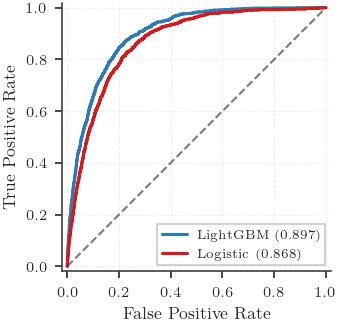

In [7]:
# ROC Curve - Subfigure styling (for LaTeX side-by-side placement)
set_subfigure_style()

fig, ax = plt.subplots(figsize=FIGSIZE['subfigure'])

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_val, y_pred_proba)
fpr_logit, tpr_logit, _ = roc_curve(y_val, logit_val_proba)

auc_lgbm = roc_auc_score(y_val, y_pred_proba)
auc_logit = roc_auc_score(y_val, logit_val_proba)

ax.plot(fpr_lgbm, tpr_lgbm, color=COLORS['lgbm'], 
        label=f'LightGBM ({auc_lgbm:.3f})', linewidth=1.5)
ax.plot(fpr_logit, tpr_logit, color=COLORS['logit'], 
        label=f'Logistic ({auc_logit:.3f})', linewidth=1.5)
ax.plot([0, 1], [0, 1], color=COLORS['neutral'], linestyle='--', 
        linewidth=1, alpha=0.7)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
# Legend in lower-right with smaller font, titled "AUC"
ax.legend(loc='lower right', fontsize=6, title_fontsize=7)
ax.set_aspect('equal')
despine(ax)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'roc_curve.pdf')
plt.show()

reset_to_standalone_style()

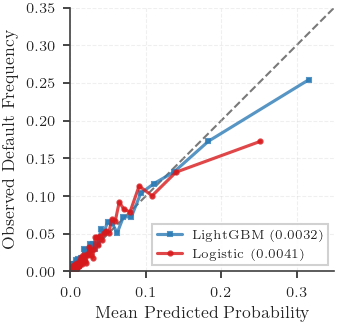

In [8]:
# Calibration Curve - Subfigure styling (for LaTeX side-by-side placement)
lgbm_ece = compute_ece(y_val, y_pred_proba)
logit_ece = compute_ece(y_val, logit_val_proba)

set_subfigure_style()

fig, ax = plt.subplots(figsize=FIGSIZE['subfigure'])

fraction_pos_lgbm, mean_pred_lgbm = calibration_curve(y_val, y_pred_proba, n_bins=100, strategy='quantile')
fraction_pos_logit, mean_pred_logit = calibration_curve(y_val, logit_val_proba, n_bins=100, strategy='quantile')

ax.plot(mean_pred_lgbm, fraction_pos_lgbm, 's-', color=COLORS['lgbm'], 
        label=f'LightGBM ({lgbm_ece:.4f})', linewidth=1.5, markersize=2, alpha=0.8)
ax.plot(mean_pred_logit, fraction_pos_logit, 'o-', color=COLORS['logit'], 
        label=f'Logistic ({logit_ece:.4f})', linewidth=1.5, markersize=2, alpha=0.8)
add_identity_line(ax)

ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Observed Default Frequency')
ax.set_xlim(0, 0.35)
ax.set_ylim(0, 0.35)
# Legend in lower-right (empty region), titled "ECE"
ax.legend(loc='lower right', fontsize=6, title_fontsize=7)
ax.set_aspect('equal')
despine(ax)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'calibration_curve.pdf')
plt.show()

reset_to_standalone_style()

In [9]:
explainer_lgbm = shap.TreeExplainer(model)
shap_values_lgbm = explainer_lgbm.shap_values(X_val)
if isinstance(shap_values_lgbm, list):
    shap_values_lgbm = shap_values_lgbm[1]

explainer_logit = shap.LinearExplainer(logit_model, X_train_processed, feature_perturbation="interventional")

shap_values_logit = explainer_logit.shap_values(X_val_processed)

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [10]:
import pickle

results_dir = PROJ_ROOT / "results" / "xai_exploration"
results_dir.mkdir(parents=True, exist_ok=True)
cache_file = results_dir / "shap_cache.pkl"

shap_cache = {
    'shap_values_lgbm': np.asarray(shap_values_lgbm, dtype=np.float64),
    'shap_values_logit': np.asarray(shap_values_logit, dtype=np.float64),
    'explainer_lgbm': explainer_lgbm,
    'X_val': X_val,
    'y_val': y_val,
    'y_pred_proba_lgbm': np.asarray(y_pred_proba, dtype=np.float64),
    'y_pred_proba_logit': np.asarray(logit_val_proba, dtype=np.float64),
    'feature_names': X_val.columns.tolist()
}

with open(cache_file, 'wb') as f:
    pickle.dump(shap_cache, f)

# Phase 2: Global Model Understanding (Chapter 1)

In this section, we analyze what the models learned and how they differ from traditional credit theory.

In [11]:
feature_names = X_val.columns.tolist()
feature_names_processed = X_val_processed.columns.tolist()  # Different order: numeric first, then categorical

lgbm_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'lgbm_shap': np.abs(shap_values_lgbm).mean(axis=0)
})

# IMPORTANT: logit SHAP values are computed on X_val_processed, which has different column order
logit_importance_shap = pd.DataFrame({
    'feature': feature_names_processed,  # Use processed column order to match SHAP values
    'logit_shap': np.abs(shap_values_logit).mean(axis=0)
})

lgbm_importance_gain = pd.DataFrame({
    'feature': feature_names,
    'lgbm_gain': model.feature_importances_
})

logit_coefficients = pd.DataFrame({
    'feature': feature_names_processed,  # Coefficients also follow processed order
    'logit_coef': np.abs(logit_model.coef_[0])
})

importance_comparison = (
    lgbm_importance_shap
    .merge(logit_importance_shap, on='feature')
    .merge(lgbm_importance_gain, on='feature')
    .merge(logit_coefficients, on='feature')
)

for col in ['lgbm_shap', 'logit_shap', 'lgbm_gain', 'logit_coef']:
    importance_comparison[f'{col}_norm'] = 100 * importance_comparison[col] / importance_comparison[col].max()

importance_comparison['lgbm_shap_rank'] = importance_comparison['lgbm_shap'].rank(ascending=False)
importance_comparison['logit_shap_rank'] = importance_comparison['logit_shap'].rank(ascending=False)

important_features = importance_comparison.nlargest(20, 'lgbm_shap')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'lgbm_shap_norm', 'logit_shap_norm', 'lgbm_gain_norm', 'logit_coef_norm']
]
important_features['rank_diff'] = important_features['logit_shap_rank'] - important_features['lgbm_shap_rank']
important_features['feature'] = important_features['feature'].apply(get_display_name)
important_features

,feature,lgbm_shap_rank,logit_shap_rank,lgbm_shap_norm,logit_shap_norm,lgbm_gain_norm,logit_coef_norm,rank_diff
15,Dividend Payer,1.0,2.0,100.000000,69.398216,8.478803,39.332490,1.0
13,Cash Ratio,2.0,1.0,82.654309,100.000000,40.773067,100.000000,-1.0
1,Industry (SNI),3.0,4.0,54.784529,28.566959,100.000000,19.887661,1.0
3,Debt Ratio,4.0,17.0,52.289730,4.273415,31.296758,4.739400,13.0
0,Company Age,5.0,5.0,48.998783,26.599740,35.785536,31.149460,0.0
9,Log Total Assets,6.0,7.0,42.191473,12.391070,47.007481,14.441978,1.0
5,Return on Equity,7.0,21.0,38.136228,2.436828,37.281796,2.912826,14.0
2,Total Asset Turnover,8.0,10.0,36.732560,7.335137,44.513716,8.768501,2.0
12,Interest Coverage,9.0,3.0,30.282678,36.530061,51.371571,31.013127,-6.0
18,Revenue CAGR (3Y),10.0,15.0,29.261536,5.005102,43.890274,5.028552,5.0


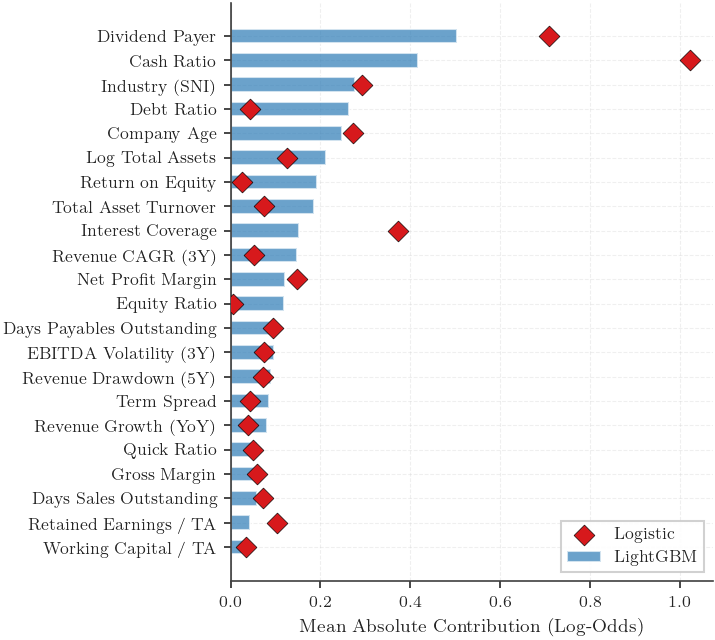

In [12]:
# Feature Importance Comparison Visualization
fig, ax = plt.subplots(figsize=FIGSIZE['standalone_tall'])

# Get all features sorted by LightGBM SHAP
top_lgbm_features = importance_comparison.copy()
top_lgbm_features = top_lgbm_features.sort_values('lgbm_shap')

y_pos = np.arange(len(top_lgbm_features))

# Plot LightGBM SHAP as bars
ax.barh(y_pos, top_lgbm_features['lgbm_shap'], 
        color=COLORS['lgbm'], alpha=0.7, label='LightGBM', height=0.6)

# Overlay Logit SHAP as markers
ax.scatter(top_lgbm_features['logit_shap'], y_pos, 
           color=COLORS['logit'], s=50, marker='D', 
           label='Logistic', zorder=3, edgecolors='black', linewidths=0.3)

# Map feature names to display names for y-axis labels
display_labels = [get_display_name(f) for f in top_lgbm_features['feature']]

# Finance-style axis label
ax.set_xlabel('Mean Absolute Contribution (Log-Odds)')
ax.set_yticks(y_pos)
ax.set_yticklabels(display_labels)
ax.legend(loc='lower right')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
despine(ax)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'shap_importance_comparison.pdf')
plt.show()

In [13]:
# SHAP Beeswarm Plots - Top 12 features
shap_values_lgbm_plot = np.asarray(shap_values_lgbm, dtype=np.float64)
shap_values_logit_plot = np.asarray(shap_values_logit, dtype=np.float64)

X_val_display = X_val.rename(columns=lambda c: get_display_name(c))
X_val_processed_display = X_val_processed.rename(columns=lambda c: get_display_name(c))


# LightGBM SHAP Summary
fig, ax = plt.subplots(figsize=FIGSIZE['medium_tall'])
shap.summary_plot(shap_values_lgbm_plot, X_val_display, max_display=10, show=False)
plt.gca().set_xlabel('SHAP Value (Log-Odds)')
plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'shap_beeswarm_lgbm.pdf')
plt.close()

# Logistic SHAP Summary
fig, ax = plt.subplots(figsize=FIGSIZE['medium_tall'])
shap.summary_plot(shap_values_logit_plot, X_val_processed_display, max_display=10, show=False)
plt.gca().set_xlabel('SHAP Value (Log-Odds)')
plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'shap_beeswarm_logit.pdf')
plt.close()

plt.show()

In [14]:
top_features = importance_comparison['feature'].tolist()

# Filter out categorical features first, then split into continuous vs binary
non_categorical = [f for f in top_features if f in X_val.columns and X_val[f].dtype.name != 'category']
continuous_features = [f for f in non_categorical if FEATURE_BOUNDS.get(f) is not None]
binary_features = [f for f in non_categorical if FEATURE_BOUNDS.get(f) is None]

def predict_lgbm(X):
    return model.predict_proba(X)

def predict_logit(X):
    return logit_model.predict_proba(X)

ale_results = {}

for i, feature in enumerate(binary_features, 1):
    print(f"[B{i}/{len(binary_features)}] {feature}...")
    ale_results[feature] = {'is_binary': True}
    
    grid_lgbm, ale_lgbm, bounds_lgbm = compute_ale_binary(predict_lgbm, X_val, feature)
    ale_results[feature]['lgbm'] = {'grid': grid_lgbm, 'ale': ale_lgbm, 'bounds': bounds_lgbm}
    
    grid_logit, ale_logit, bounds_logit = compute_ale_binary(predict_logit, X_val, feature)
    ale_results[feature]['logit'] = {'grid': grid_logit, 'ale': ale_logit, 'bounds': bounds_logit}

for i, feature in enumerate(continuous_features, 1):
    print(f"[{i}/{len(continuous_features)}] {feature}...")
    bounds = FEATURE_BOUNDS.get(feature)
    ale_results[feature] = {}
    
    grid_lgbm, ale_lgbm, bounds_lgbm = compute_ale_for_feature(predict_lgbm, X_val, feature, feature_bounds=bounds)
    ale_results[feature]['lgbm'] = {'grid': grid_lgbm, 'ale': ale_lgbm, 'bounds': bounds_lgbm}
    
    grid_logit, ale_logit, bounds_logit = compute_ale_for_feature(predict_logit, X_val, feature, feature_bounds=bounds)
    ale_results[feature]['logit'] = {'grid': grid_logit, 'ale': ale_logit, 'bounds': bounds_logit}

[B1/1] dividend_yield...
[1/20] company_age...
[2/20] ny_kapomsh...
[3/20] ny_skuldgrd...
[4/20] ny_solid...
[5/20] ny_avkegkap...
[6/20] ny_kasslikv...
[7/20] ny_nettomarg...
[8/20] ny_omsf...
[9/20] log_total_assets...
[10/20] working_capital_ta...
[11/20] retained_earnings_ta...
[12/20] interest_coverage...
[13/20] ratio_cash_liquidity...
[14/20] gross_margin...
[15/20] dso_days...
[16/20] dpo_days...
[17/20] revenue_cagr_3y...
[18/20] revenue_drawdown_5y...
[19/20] ebitda_volatility...
[20/20] term_spread...


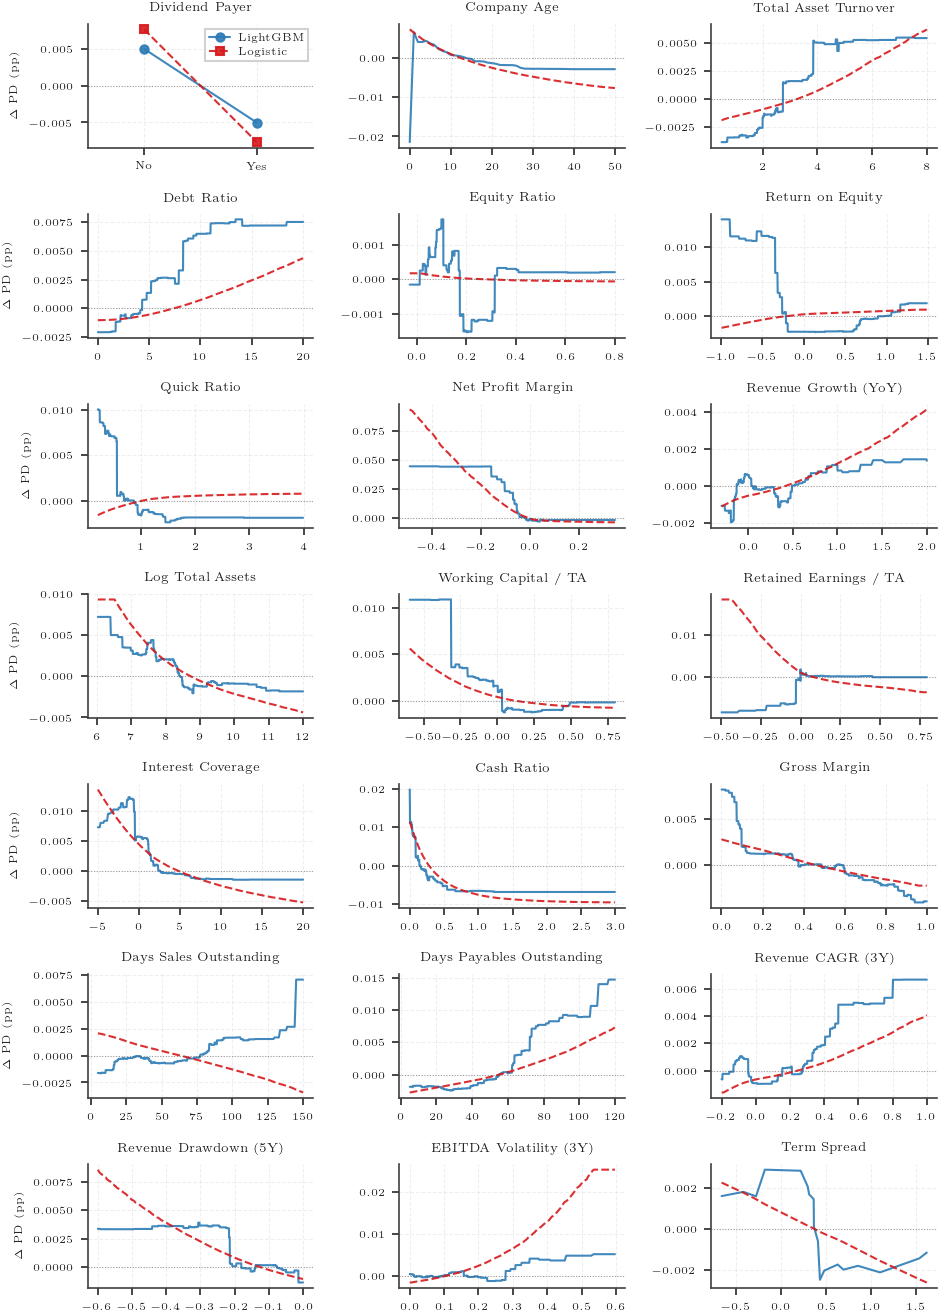

In [ ]:
# ALE Full Grid - All Features (sized to fit on single appendix page)
n_plots = len(ale_results)

# 7 columns x 3 rows = 21 plots, fits on one page
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

# Page-sized figure: ~6.5in wide (text width), ~9in tall (fits with caption)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6.5, 9.0))
axes = axes.flatten()

for idx, (feature, data) in enumerate(ale_results.items()):
    ax = axes[idx]
    display_name = get_display_name(feature)
    
    has_lgbm = 'lgbm' in data and len(data['lgbm']['grid']) > 0
    has_logit = 'logit' in data and len(data['logit']['grid']) > 0
    
    if not has_lgbm and not has_logit:
        ax.text(0.5, 0.5, f"{display_name}\n(no data)", 
                ha='center', va='center', transform=ax.transAxes, fontsize=6)
        ax.set_title(display_name, fontsize=6, fontweight='bold')
        continue
    
    is_binary = data.get('is_binary', False)
    
    if has_lgbm:
        ax.plot(data['lgbm']['grid'], data['lgbm']['ale'], 
                label='LightGBM', linewidth=1.0, color=COLORS['lgbm'], alpha=0.9,
                marker='o' if is_binary else None, markersize=4)
    
    if has_logit:
        ax.plot(data['logit']['grid'], data['logit']['ale'], 
                label='Logistic', linewidth=1.0, color=COLORS['logit'], alpha=0.9, 
                linestyle='--', marker='s' if is_binary else None, markersize=4)
    
    ax.axhline(y=0, color=COLORS['neutral'], linestyle=':', linewidth=0.5, alpha=0.5)
    
    if not is_binary:
        all_x = []
        if has_lgbm:
            all_x.extend(data['lgbm']['grid'])
        if has_logit:
            all_x.extend(data['logit']['grid'])
        if len(all_x) > 0:
            all_x = np.array(all_x)
            x_padding = (all_x.max() - all_x.min()) * 0.05
            ax.set_xlim(all_x.min() - x_padding, all_x.max() + x_padding)
    
    if is_binary:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['No', 'Yes'], fontsize=5)
        ax.set_xlim(-0.5, 1.5)
    
    ax.set_title(display_name, fontsize=6, fontweight='bold')
    if idx % n_cols == 0:
        ax.set_ylabel(r'$\Delta$ PD', fontsize=5)
    ax.tick_params(labelsize=5)
    despine(ax)
    
    # Only show legend on first plot
    if idx == 0:
        ax.legend(loc='best', fontsize=5)

# Turn off unused axes
for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'ale_full.pdf')
plt.show()

In [32]:
# Individual ALE Plots for Selected Features
SELECTED_ALE_FEATURES = [
    'ny_avkegkap', 'company_age', 'ratio_cash_liquidity', 'interest_coverage',
    'dpo_days', 'ny_kapomsh', 'ny_nettomarg', 'ny_skuldgrd'
]

# Slightly more rectangular figure for ALE plots
ale_figsize = (3, 1.8)

for feature in SELECTED_ALE_FEATURES:
    if feature not in ale_results:
        continue
    
    data = ale_results[feature]
    display_name = get_display_name(feature)
    filename = get_ale_filename(feature)
    
    has_lgbm = 'lgbm' in data and len(data['lgbm']['grid']) > 0
    has_logit = 'logit' in data and len(data['logit']['grid']) > 0
    
    if not has_lgbm and not has_logit:
        continue
    
    is_binary = data.get('is_binary', False)
    fig, ax = plt.subplots(figsize=ale_figsize)
    
    if has_lgbm:
        ax.plot(data['lgbm']['grid'], data['lgbm']['ale'], 
                label='LightGBM', linewidth=1.5, color=COLORS['lgbm'],
                marker='o' if is_binary else None, markersize=6)
    
    if has_logit:
        ax.plot(data['logit']['grid'], data['logit']['ale'], 
                label='Logistic', linewidth=1.5, color=COLORS['logit'],
                marker='s' if is_binary else None, markersize=6)
    
    ax.axhline(y=0, color=COLORS['neutral'], linestyle=':', linewidth=0.8, alpha=0.5)
    ax.set_xlabel(display_name)
    # Finance-style y-axis label
    ax.set_ylabel(r'$\Delta$ Prob. of Default')
    ax.legend(loc='best')
    despine(ax)
    
    plt.tight_layout()
    save_figure(fig, FIGURES_DIR / filename)
    plt.close()

In [17]:
np.random.seed(42)
sample_size = min(10000, len(X_val))
sample_idx = np.random.choice(len(X_val), size=sample_size, replace=False)
X_val_sample = X_val.iloc[sample_idx]

shap_interaction_values = explainer_lgbm.shap_interaction_values(X_val_sample)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

interaction_matrix = np.abs(shap_interaction_values).mean(axis=0)
np.fill_diagonal(interaction_matrix, 0)

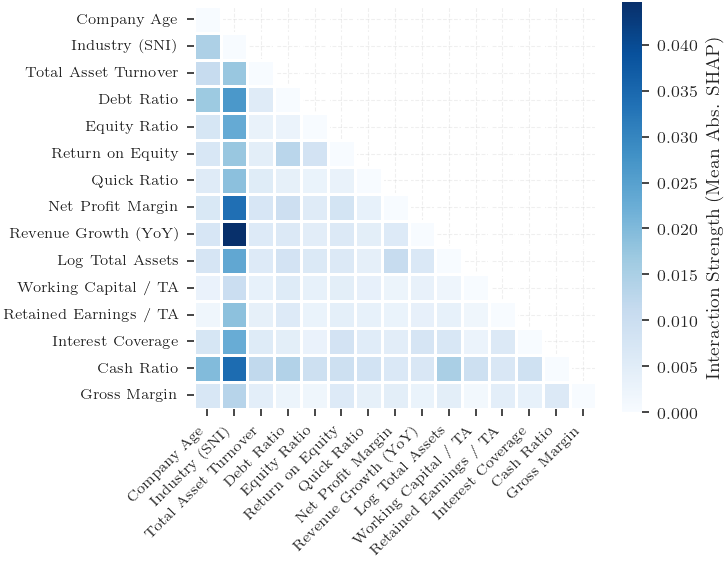

In [18]:
# SHAP Interaction Heatmap - Lower Triangle Only (symmetric matrix)
fig, ax = plt.subplots(figsize=FIGSIZE['standalone_tall'])

top_15_features = importance_comparison.head(15)['feature'].tolist()
top_15_indices = [X_val.columns.get_loc(f) for f in top_15_features]
top_15_display_names = [get_display_name(f) for f in top_15_features]
interaction_submatrix = interaction_matrix[np.ix_(top_15_indices, top_15_indices)]

# Create mask for upper triangle (keep lower triangle + diagonal visible)
mask = np.triu(np.ones_like(interaction_submatrix, dtype=bool), k=1)

# Use seaborn heatmap with mask for cleaner visualization
# Finance-style colorbar label
sns.heatmap(interaction_submatrix, mask=mask, cmap='Blues', 
            xticklabels=top_15_display_names, yticklabels=top_15_display_names,
            square=True, linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Interaction Strength (Mean Abs. SHAP)', 'shrink': 0.8},
            ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'shap_interaction_heatmap.pdf')
plt.show()

In [19]:
feature_names = X_val.columns.tolist()

main_effects_per_sample = np.array([
    shap_interaction_values[i].diagonal() for i in range(len(shap_interaction_values))
])
total_main_effect = np.abs(main_effects_per_sample).sum(axis=1)

interaction_effects_per_sample = np.array([
    np.abs(shap_interaction_values[i]).sum() - np.abs(shap_interaction_values[i].diagonal()).sum()
    for i in range(len(shap_interaction_values))
]) / 2

total_effect = total_main_effect + interaction_effects_per_sample
interaction_ratio_per_sample = interaction_effects_per_sample / total_effect

sample_preds = model.predict_proba(X_val_sample)[:, 1]
risk_df = pd.DataFrame({
    'sample_idx': sample_idx,
    'predicted_prob': sample_preds,
    'main_effect': total_main_effect,
    'interaction_effect': interaction_effects_per_sample,
    'interaction_ratio': interaction_ratio_per_sample
})
risk_df['risk_decile'] = pd.qcut(risk_df['predicted_prob'], 10, labels=[f'D{i+1}' for i in range(10)])

y_pred_sample = sample_preds

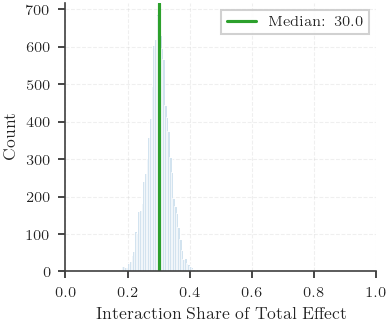

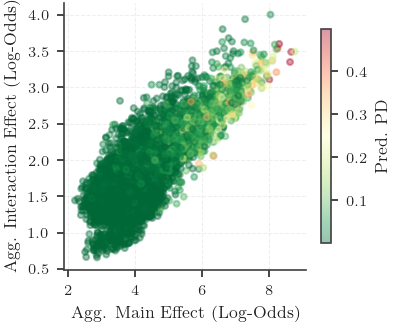

In [20]:
# Interaction Importance Analysis - Separate Figures for Subfigure Layout
# Figure 1: Histogram of interaction ratios
set_subfigure_style()
fig1, ax1 = plt.subplots(figsize=FIGSIZE['subfigure'])

ax1.hist(interaction_ratio_per_sample, bins=50, color=COLORS['lgbm'], alpha=0.7, edgecolor='white')
ax1.axvline(x=np.median(interaction_ratio_per_sample), color='#2ca02c', linestyle='-', 
            linewidth=1.5, label=f'Median: {np.median(interaction_ratio_per_sample):.1%}')
# Finance-style axis label
ax1.set_xlabel('Interaction Share of Total Effect')
ax1.set_ylabel('Count')
ax1.legend(loc='upper right')
ax1.set_xlim(0, 1)
despine(ax1)

plt.tight_layout()
save_figure(fig1, FIGURES_DIR / 'interaction_ratio_histogram.pdf')
plt.show()

# Figure 2: Scatter plot of main vs interaction effects
fig2, ax2 = plt.subplots(figsize=FIGSIZE['subfigure'])

scatter = ax2.scatter(total_main_effect, interaction_effects_per_sample, 
                      c=y_pred_sample, cmap='RdYlGn_r', alpha=0.4, s=8, rasterized=True)
# Finance-style axis labels
ax2.set_xlabel('Agg. Main Effect (Log-Odds)')
ax2.set_ylabel('Agg. Interaction Effect (Log-Odds)')
cbar = plt.colorbar(scatter, ax=ax2, shrink=0.8)
cbar.set_label('Pred. PD', fontsize=8)
cbar.ax.tick_params(labelsize=7)
despine(ax2)

plt.tight_layout()
save_figure(fig2, FIGURES_DIR / 'interaction_scatter.pdf')
plt.show()

reset_to_standalone_style()